In [1]:
from pylab import *  
import numpy as np

In [2]:
#--- precipitable water vapor (g/cm2)
uw = [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0, 3.25, 3.5, 3.75, 4.0]

#--- surface skin temperature (K)
temps = [270, 275, 280, 285, 290, 295, 300]

#--- folder path
folder = 'figure_alb_01/'

In [3]:
def read_sbdart_data(filename):
    f_raw = loadtxt(filename,delimiter="\t",skiprows=3,dtype='str')
    f = f_raw[::3]

    WL=[] #--- wavelength (um)
    FFV=[] #--- filter value
    TOPDN=[] #--- downwelling flux to the top of the atmosphere (TOA, W/cm2/um)
    TOPUP=[] #--- TOA upwelling flux
    TOPDIR=[] #--- TOA direct flux
    BOTDN=[] #--- downwelling flux at surface
    BOTUP=[] #--- upwelling flux at surface
    BOTDIR=[] #--- direct flux at surface

    for row in f:
        row = row[1:]
        row = row.replace('  ',' ')
        row = row.lstrip()
        split_row = row.split(' ')
        #print(split_row)
    
        WL.append(float(split_row[0]))
        FFV.append(float(split_row[1]))
        TOPDN.append(float(split_row[2]))
        TOPUP.append(float(split_row[3]))
        TOPDIR.append(float(split_row[4]))
        BOTDN.append(float(split_row[5]))
        BOTUP.append(float(split_row[6]))
        BOTDIR.append(float(split_row[7]))

    return TOPUP

In [4]:
flux_lw_290 = read_sbdart_data(folder+'11um_290')
flux_sw_290 = read_sbdart_data(folder+'39um_290')

In [5]:
flux_lw_290

[23.072,
 23.14,
 23.141,
 23.143,
 23.141,
 23.132,
 23.112,
 23.078,
 23.026,
 22.957,
 22.869,
 22.763,
 22.64,
 22.503,
 22.352,
 22.19,
 22.019]

In [6]:
flux_sw_290

[1.0179,
 1.0157,
 1.0138,
 1.0118,
 1.0098,
 1.0078,
 1.0058,
 1.0038,
 1.0017,
 0.9996,
 0.99747,
 0.99532,
 0.99314,
 0.99093,
 0.98869,
 0.98643,
 0.98414]

#### Calculate the brightness temperature difference: 

* sbdart gives the flux density in w/m2/micron
* this can be easily converted to brightness temperature ($T_B$) with an inversion of Planck's equation: 
    * $\lambda$: wavelength
    * $\Omega$: beam solid angle
    * $S$: flux density
 
$$
T_b = \frac{c_2}{\lambda \text{ ln}(\frac{c_1}{\lambda^5 S}+1)}
$$

In [7]:
def flux_to_Tb(flux, wl):
    c1 = 3.74e-22
    c2 = 0.0144
    S = np.array(flux) #W m-2 um-1
    
    T_b = c2/(wl*np.log((c1/((wl**5)*S)+1)))
    
    return T_b

In [8]:
data = {}

for t in temps:
    flux_lw = read_sbdart_data(folder+'11um_'+str(t))
    flux_sw = read_sbdart_data(folder+'39um_'+str(t))
    
    
    BTD = flux_to_Tb(flux_lw, 11e-6) - flux_to_Tb(flux_sw, 3.9e-6)
    #print(BTD)

    for i in range(len(uw)):
        data[t, uw[i]] = BTD[i]

data

{(270, 0.0): -3.9631474009528915,
 (270, 0.25): -3.8335565233069815,
 (270, 0.5): -3.5015075209825,
 (270, 0.75): -3.0170600790728486,
 (270, 1.0): -2.4144325119189034,
 (270, 1.25): -1.7304958393312972,
 (270, 1.5): -1.004270708175227,
 (270, 1.75): -0.2700347139401629,
 (270, 2.0): 0.4408663183416479,
 (270, 2.25): 1.1122840469017774,
 (270, 2.5): 1.720049550637441,
 (270, 2.75): 2.2609065577092906,
 (270, 3.0): 2.7210368526373827,
 (270, 3.25): 3.1043254407601353,
 (270, 3.5): 3.4127391008784684,
 (270, 3.75): 3.646774504282405,
 (270, 4.0): 3.8104860384569292,
 (275, 0.0): -3.4699451176267644,
 (275, 0.25): -3.309183289556586,
 (275, 0.5): -3.0516891223529683,
 (275, 0.75): -2.6780701416493002,
 (275, 1.0): -2.2201575392829795,
 (275, 1.25): -1.7086772347575447,
 (275, 1.5): -1.1711768405000385,
 (275, 1.75): -0.6345754605036404,
 (275, 2.0): -0.12514436901750514,
 (275, 2.25): 0.3434218825631774,
 (275, 2.5): 0.753702724971788,
 (275, 2.75): 1.1043600141994148,
 (275, 3.0): 1.3875

In [9]:
x_values, y_values, values = zip(*[(x, y, value) for (x, y), value in data.items()])

In [10]:
btd_grid = np.array(values).reshape(len(temps), len(uw))
uw_grid, temp_grid = np.meshgrid(uw, temps)

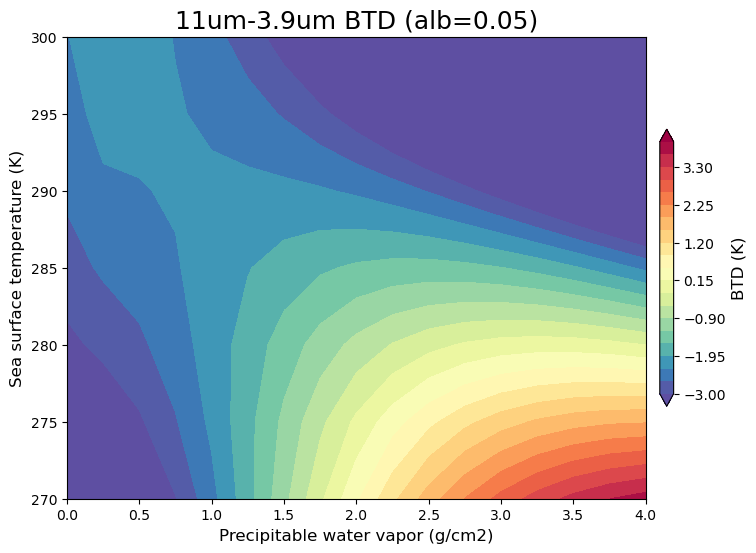

In [11]:
fig,ax=plt.subplots(1, figsize=(9,6))
cmap = plt.cm.Spectral_r
levels = np.linspace(-3, 4, 21)

c=ax.contourf(uw_grid, temp_grid, btd_grid, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.6, pad=0.02, ax=ax)
ax.set_title('11um-3.9um BTD (alb=0.05)', fontsize=18)
ax.set_ylabel('Sea surface temperature (K)', fontsize=12)
ax.set_xlabel('Precipitable water vapor (g/cm2)', fontsize=12)
clb.set_label('BTD (K)', fontsize=12)
plt.savefig('sbdart_sst_wv.png', dpi=200, bbox_inches='tight')